# Análise Estatística: SmartRefactor vs. Refatoração Tradicional

Este notebook reproduz, em células interativas, todo o fluxo de análise realizado no script Python:
- Carregamento e limpeza dos dados
- Estatísticas descritivas
- Testes de hipótese
- Análise de perfil dos participantes
- Geração de gráficos (boxplots)

As chamadas abaixo seguem exatamente a lógica e o código final do script fornecido.

## 1. Configuração de Ambiente e Importações

In [26]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
from IPython.display import display
from scipy.stats import levene

# Caminhos para os arquivos e diretório de saída
metrics_csv = Path("./coleta.csv")
profile_csv = Path("./perfil_dos_participantes.csv")
profile = pd.read_csv(profile_csv)
metrics = pd.read_csv(metrics_csv)
out_dir = Path("./results")
out_dir.mkdir(parents=True, exist_ok=True)

## 2. Função `load_metrics`
Leitura e limpeza dos dados de métricas.

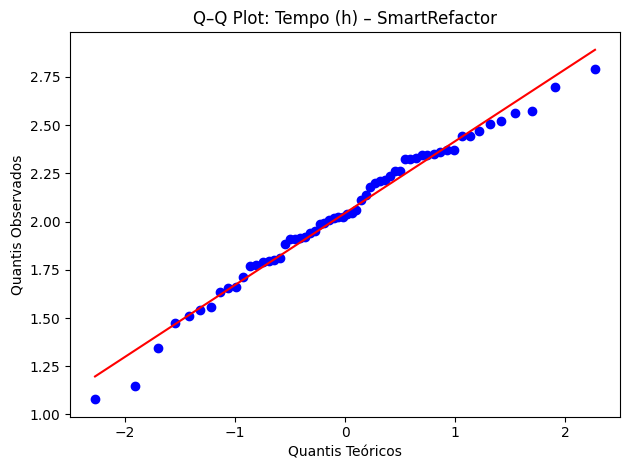

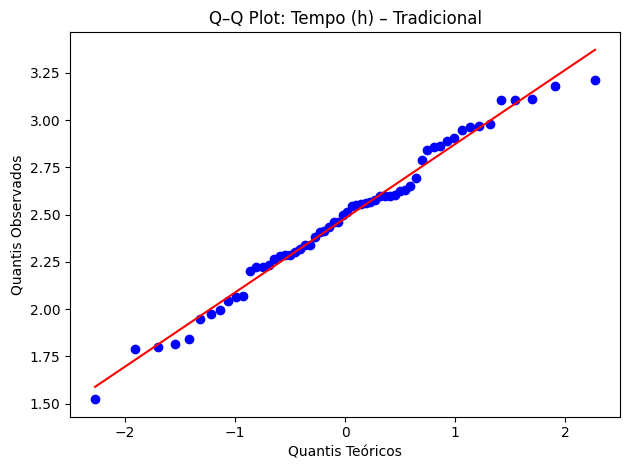

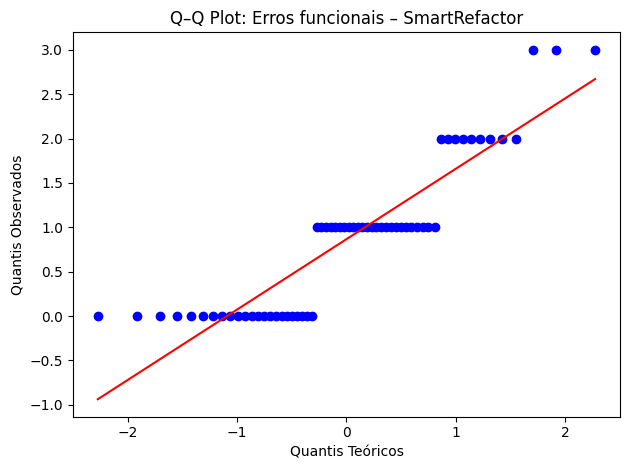

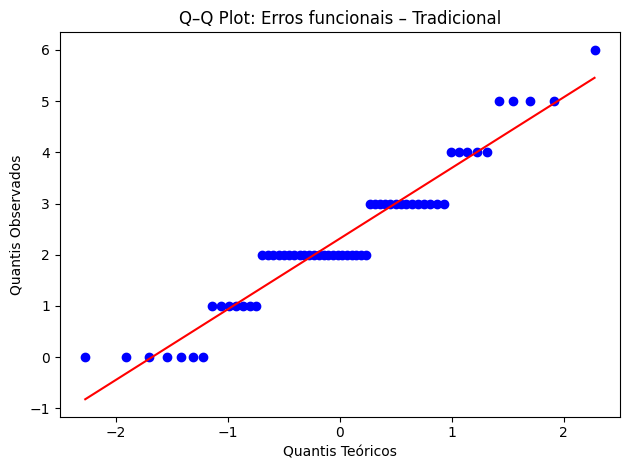

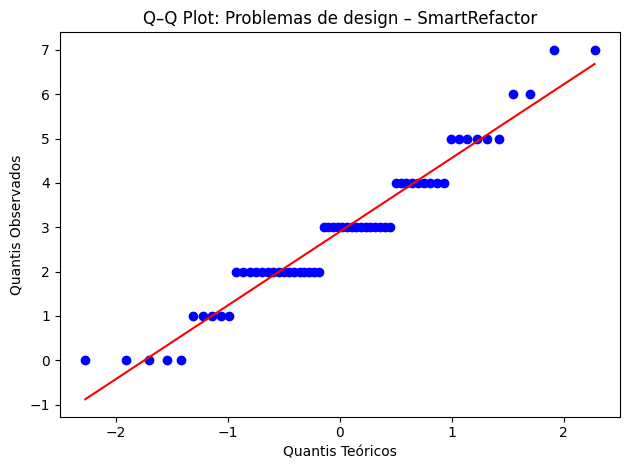

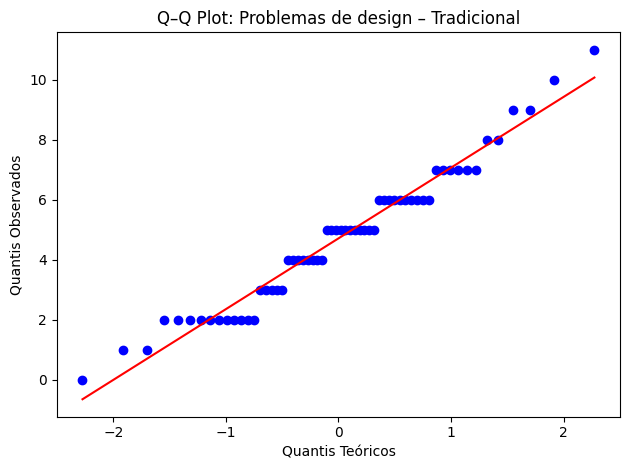

In [ ]:
def load_metrics(df_raw):
    rename = {
        "Tempo (h)": "tempo_h",
        "LOC Modificadas": "loc_mod",
        "Erros Funcionais": "erros",
        "Problemas de Design": "design",
        "Ferramenta": "ferramenta",
    }
    df = df_raw.rename(columns=rename)
    for col in ["tempo_h", "loc_mod"]:
        df[col] = df[col].astype(str).str.strip()\
                                 .str.replace(",", ".", regex=False)\
                                 .astype(float)
    df["erros"] = pd.to_numeric(df["erros"], errors="coerce")
    df["design"] = pd.to_numeric(df["design"], errors="coerce")
    df = df[["ID", "tempo_h", "erros", "design", "ferramenta"]]
    return df

# Carregar e exibir as cinco primeiras linhas
df_metrics = load_metrics(metrics)
df_metrics.head()

def qq_plot(series, title):
    fig, ax = plt.subplots()
    stats.probplot(series.dropna(), dist=stats.norm, plot=ax)
    ax.get_lines()[1].set_color('red')
    ax.set_title(title)
    ax.set_xlabel("Quantis Teóricos")
    ax.set_ylabel("Quantis Observados")
    plt.tight_layout()
    plt.show()

# Converter Tempo (h) para float
metrics['tempo_h'] = (
    metrics['Tempo (h)']
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# Converter Erros Funcionais
metrics['erros'] = (
    metrics['Erros Funcionais']
    .astype(str)                     
    .str.replace(",", ".", regex=False)
    .astype(float)                 
)

# Converter Problemas de Design
metrics['design'] = (
    metrics['Problemas de Design']
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)


# Q–Q plot para tempo:
qq_plot(
    metrics.loc[metrics['Ferramenta']=="SmartRefactor", 'tempo_h'],
    title="Q–Q Plot: Tempo (h) – SmartRefactor"
)

qq_plot(
    metrics.loc[metrics['Ferramenta']=="Tradicional", 'tempo_h'],
    title="Q–Q Plot: Tempo (h) – Tradicional"
)

# Q–Q plot para Erros Funcionais:
qq_plot(
    metrics.loc[metrics['Ferramenta']=="SmartRefactor", 'erros'],
    title="Q–Q Plot: Erros funcionais – SmartRefactor"
)

qq_plot(
    metrics.loc[metrics['Ferramenta']=="Tradicional", 'erros'],
    title="Q–Q Plot: Erros funcionais – Tradicional"
)

# Q–Q plot para Problemas de Design:
qq_plot(
    metrics.loc[metrics['Ferramenta']=="SmartRefactor", 'design'],
    title="Q–Q Plot: Problemas de design – SmartRefactor"
)

qq_plot(
    metrics.loc[metrics['Ferramenta']=="Tradicional", 'design'],
    title="Q–Q Plot: Problemas de design – Tradicional"
)

## 3. Função `load_profile`
Leitura dos dados de perfil dos participantes.

In [28]:
def load_profile(df):
    rename = {
        "Formacao": "formacao",
        "Experiencia": "experiencia",
        "Conhecimento_Refatoracao": "kn_ref",
        "Conhecimento_Java": "kn_java"
    }
    return df.rename(columns=rename)

df_profile = load_profile(profile)
df_profile.head()

,ID,formacao,experiencia,kn_ref,kn_java,Genero,FaixaEtaria,AreaAtuacao,Regiao
0,P1,Mestrado,6+ anos,Nenhum,Razoável,Masculino,35-44,Estudante,Sudeste
1,P2,Graduação,1-2 anos,Razoável,Básico,Feminino,35-44,Estudante,Nordeste
2,P3,Graduação,1-2 anos,Avançado,Razoável,Feminino,<25,Estudante,Nordeste
3,P4,Mestrado,3-5 anos,Básico,Básico,Masculino,<25,Indústria,Sudeste
4,P5,Mestrado,6+ anos,Nenhum,Básico,Masculino,<25,Indústria,Sudeste


## 4. União dos DataFrames
Merge por `ID` para relacionar perfil e métricas.

In [29]:
df = pd.merge(df_metrics, df_profile, on="ID", how="left")
df.head()

,ID,tempo_h,erros,design,ferramenta,formacao,experiencia,kn_ref,kn_java,Genero,FaixaEtaria,AreaAtuacao,Regiao
0,P1,2.600586,3,3,Tradicional,Mestrado,6+ anos,Nenhum,Razoável,Masculino,35-44,Estudante,Sudeste
1,P2,2.222081,2,5,Tradicional,Graduação,1-2 anos,Razoável,Básico,Feminino,35-44,Estudante,Nordeste
2,P3,2.855597,2,5,Tradicional,Graduação,1-2 anos,Avançado,Razoável,Feminino,<25,Estudante,Nordeste
3,P4,2.964427,0,3,Tradicional,Mestrado,3-5 anos,Básico,Básico,Masculino,<25,Indústria,Sudeste
4,P5,2.460526,5,6,Tradicional,Mestrado,6+ anos,Nenhum,Básico,Masculino,<25,Indústria,Sudeste


## 5. Estatística Descritiva por Ferramenta

In [30]:
def descriptive_stats(df: pd.DataFrame):
    return (df.groupby("ferramenta")
              .agg(
                    n=("tempo_h", "count"),
                    tempo_medio=("tempo_h", "mean"),
                    tempo_dp=("tempo_h", "std"),
                    tempo_mediana=("tempo_h", "median"),
                    erros_medio=("erros", "mean"),
                    erros_dp=("erros", "std"),
                    erros_mediana=("erros", "median"),
                    design_medio=("design", "mean"),
                    design_dp=("design", "std"),
                    design_mediana=("design", "median"),
                )
                .round(3))

desc = descriptive_stats(df)
desc.to_csv(out_dir/"descriptive_stats.csv")
desc

,n,tempo_medio,tempo_dp,tempo_mediana,erros_medio,erros_dp,erros_mediana,design_medio,design_dp,design_mediana
ferramenta,,,,,,,,,,
SmartRefactor,60,2.043,0.367,2.030,0.867,0.853,1.0,2.900,1.664,3.0
Tradicional,60,2.480,0.386,2.505,2.317,1.396,2.0,4.717,2.344,5.0


## 6. Testes de Hipótese

In [42]:
def hypothesis_tests(df: pd.DataFrame):
    results = []
    for metric, label in [
        ("tempo_h", "Tempo (h)"),
        ("erros", "Erros Funcionais"),
        ("design", "Problemas de Design"),
    ]:
        grp_smart = df[df["ferramenta"] == "SmartRefactor"][metric]
        grp_trad = df[df["ferramenta"] == "Tradicional"][metric]

        p_smart = stats.shapiro(grp_smart).pvalue
        p_trad = stats.shapiro(grp_trad).pvalue
        normal = (p_smart > 0.05) and (p_trad > 0.05)

        # Verificar homogeneidade das variâncias com o teste de Levene
        stat_lev, p_lev = levene(grp_smart, grp_trad)
        igual_var = (p_lev > 0.05)

        if normal and igual_var:
            # t de Student clássico
            stat, pval = stats.ttest_ind(grp_smart, grp_trad, equal_var=True)
            test_name = "t de Student"
            # Cohen’s d
            effect = abs(grp_smart.mean() - grp_trad.mean()) / math.sqrt(
                (grp_smart.var(ddof=1) + grp_trad.var(ddof=1)) / 2
            )
        else:
            n1, n2 = len(grp_smart), len(grp_trad)
            stat, pval = stats.mannwhitneyu(grp_smart, grp_trad, alternative="two-sided")       
            mean_U = n1 * n2 / 2
            std_U  = math.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
            z_U    = (stat - mean_U) / std_U
            effect = round(abs(z_U) / math.sqrt(n1 + n2), 3)
            test_name = "Mann–Whitney"
    

        results.append({
            "Métrica": label,
            "Teste": test_name,
            "Estatística": round(stat,3),
            "p_valor": pval,
            "Normal?": normal,
            "Efeito": round(effect,3)
        })
    return pd.DataFrame(results)

hyp = hypothesis_tests(df)
pd.set_option('display.precision', 10)
display(hyp)
hyp.to_csv(
    out_dir/"hypothesis_results.csv",
    index=False,
    float_format="%.10f"
)

,Métrica,Teste,Estatística,p_valor,Normal?,Efeito
0,Tempo (h),t de Student,-6.357,0.0000000040,True,1.161
1,Erros Funcionais,Mann–Whitney,697.000,0.0000000027,False,0.528
2,Problemas de Design,Mann–Whitney,986.000,0.0000155797,False,0.390


## 7. Estatísticas do Perfil dos Participantes

,Variável,Categoria,Contagem,Percentual (%)
22,AreaAtuacao,Indústria,63,52.5
23,AreaAtuacao,Academia,33,27.5
24,AreaAtuacao,Estudante,24,20.0
18,FaixaEtaria,<25,49,40.8
19,FaixaEtaria,25-34,49,40.8
20,FaixaEtaria,35-44,18,15.0
21,FaixaEtaria,45,4,3.3
15,Genero,Masculino,83,69.2
16,Genero,Feminino,36,30.0
17,Genero,Não-binário,1,0.8


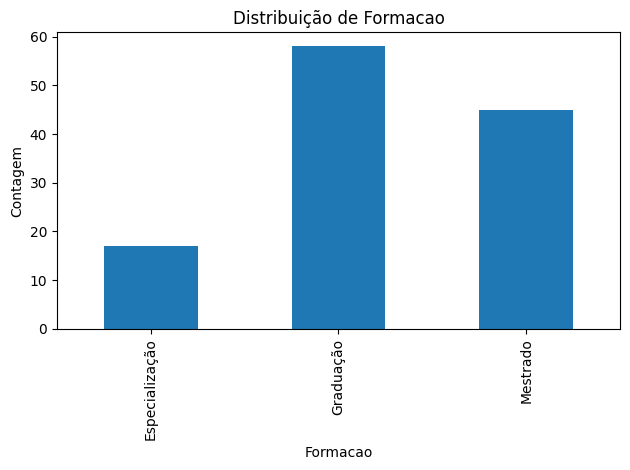

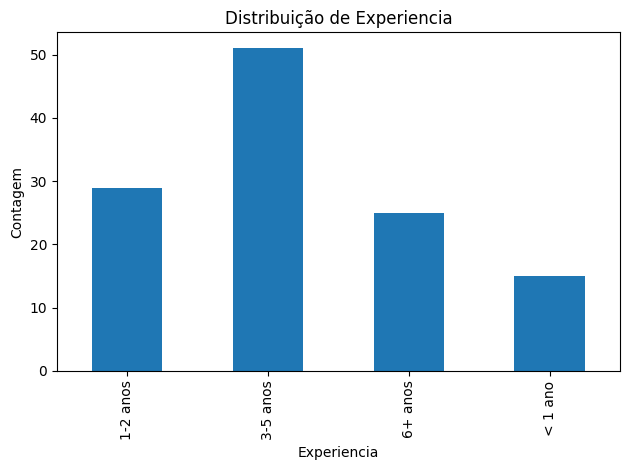

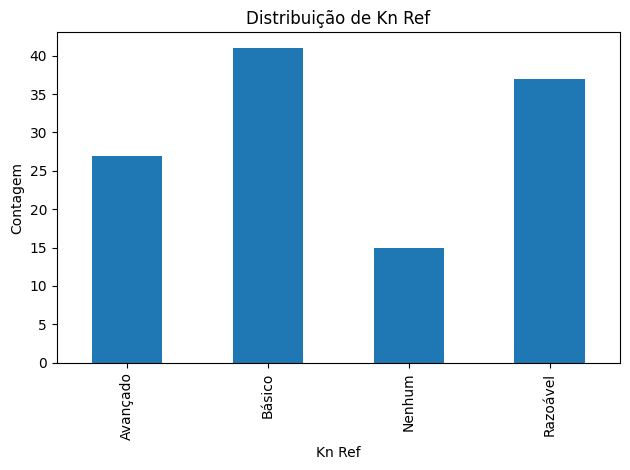

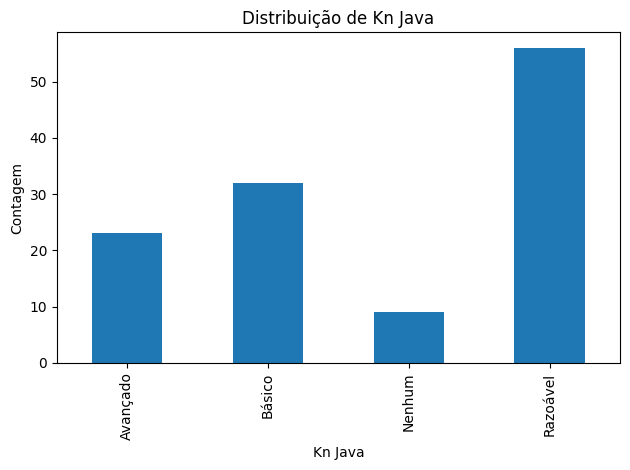

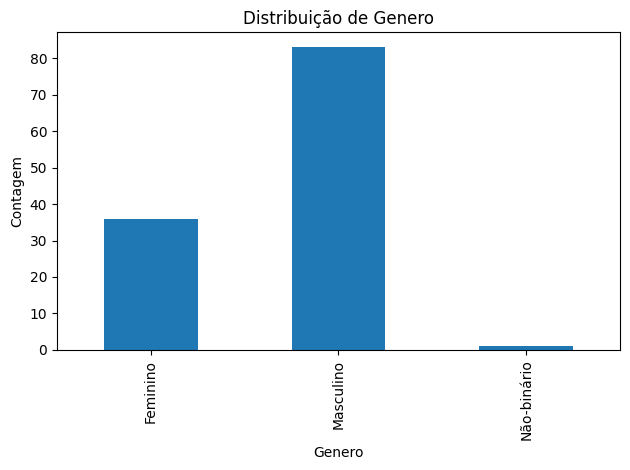

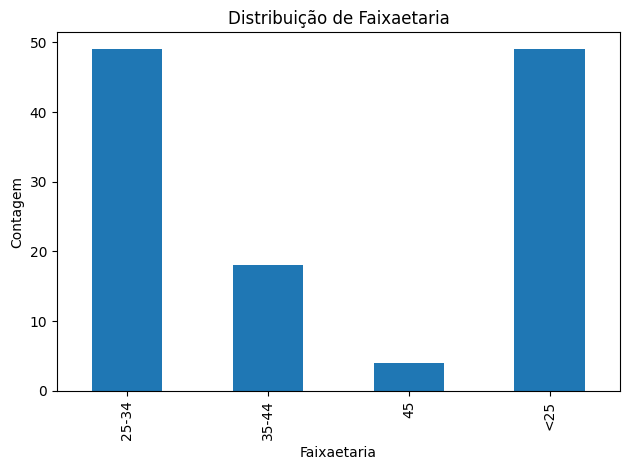

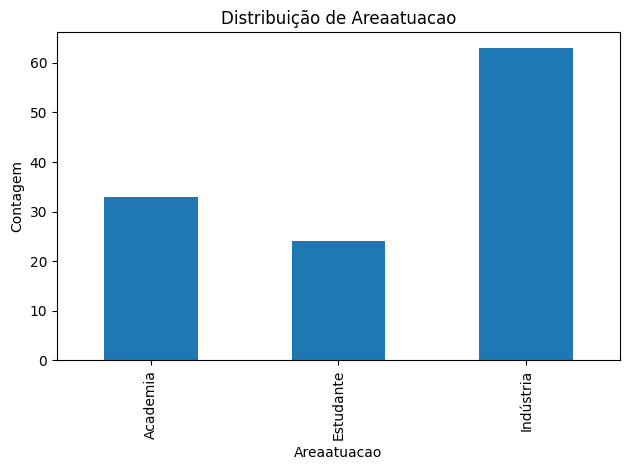

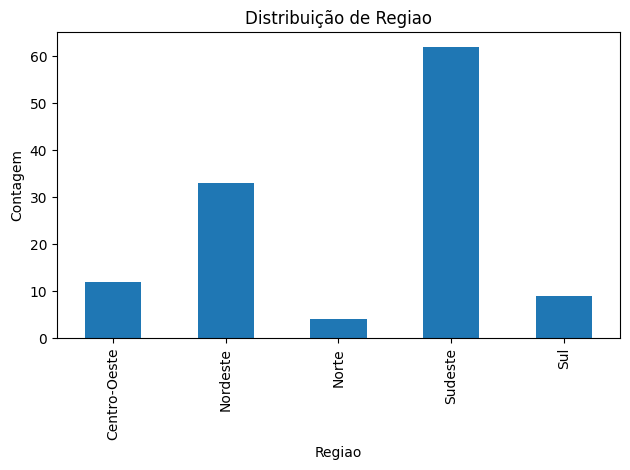

In [32]:
# Tabela tidy: Variável × Categoria × Contagem × Percentual
records = []
total = len(df_profile)
for col in df_profile.columns:
    if col == "ID":
        continue
    vc = df_profile[col].value_counts(dropna=False)
    for cat, count in vc.items():
        pct = round(count / total * 100, 1)
        records.append({
            "Variável": col,
            "Categoria": cat,
            "Contagem": int(count),
            "Percentual (%)": pct
        })

profile_stats = pd.DataFrame(records)

# Ordenar por variável e contagem e exibir
profile_stats = profile_stats.sort_values(["Variável","Contagem"], ascending=[True, False])
display(profile_stats)

# Salvar 
out_dir = Path("./results")
out_dir.mkdir(exist_ok=True)
profile_stats.to_csv(out_dir / "profile_stats.csv", index=False)


# Gráficos de Distribuição para Cada Variável de Perfil
for col in df_profile.columns:
    if col == "ID":
        continue
    plt.figure()
    counts = df_profile[col].value_counts().sort_index()
    counts.plot(kind="bar")
    plt.title(f"Distribuição de {col.replace('_',' ').title()}")
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel("Contagem")
    plt.tight_layout()
    plt.savefig(out_dir/f"profile_dist_{col}.png", dpi=300)
    plt.show()

## 8. Influência do Perfil sobre Métricas

,Variável,Métrica,Teste,Estatística,p_valor
0,Experiência,tempo_h,Spearman ρ,-0.030,0.76349
1,Experiência,erros,Spearman ρ,0.083,0.40001
2,Experiência,design,Spearman ρ,-0.058,0.55912
3,Conhecimento Refatoração,tempo_h,Spearman ρ,-0.013,0.88669
4,Conhecimento Refatoração,erros,Spearman ρ,0.141,0.12349
5,Conhecimento Refatoração,design,Spearman ρ,0.027,0.77213
6,Conhecimento Java,tempo_h,Spearman ρ,-0.075,0.41587
7,Conhecimento Java,erros,Spearman ρ,-0.043,0.63995
8,Conhecimento Java,design,Spearman ρ,-0.052,0.57438
9,Formação,tempo_h,Kruskal–Wallis,0.576,0.74971


/var/folders/m7/0vkmn80144lcqcp11ggbb3v00000gn/T/ipykernel_5908/3750328365.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=exp_order, showfliers=True)


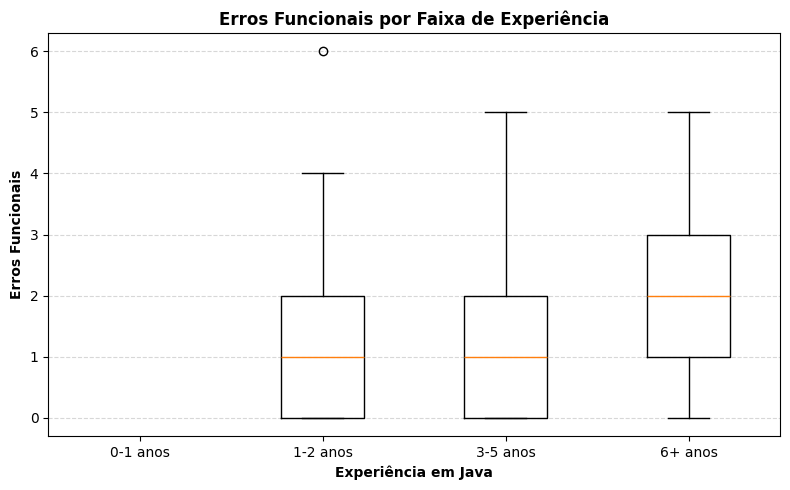

/var/folders/m7/0vkmn80144lcqcp11ggbb3v00000gn/T/ipykernel_5908/3750328365.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=regions, showfliers=True)


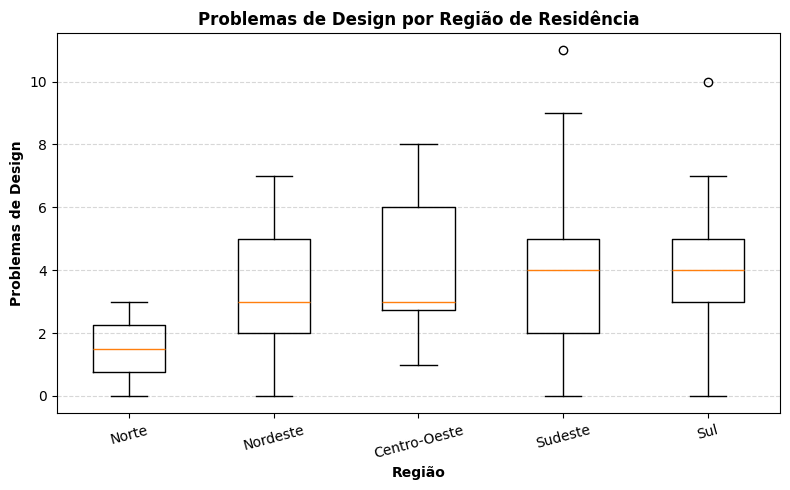

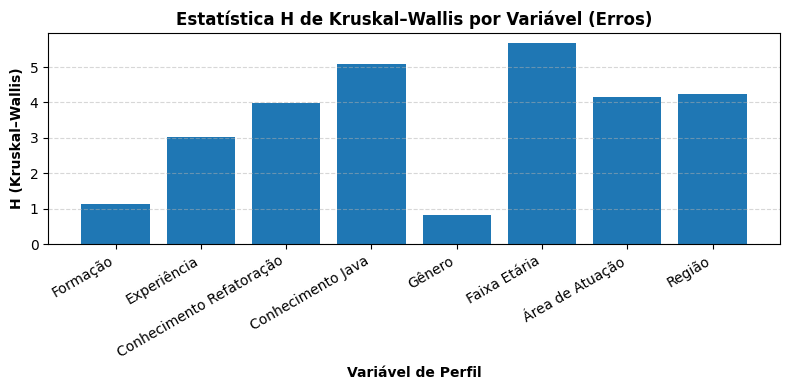

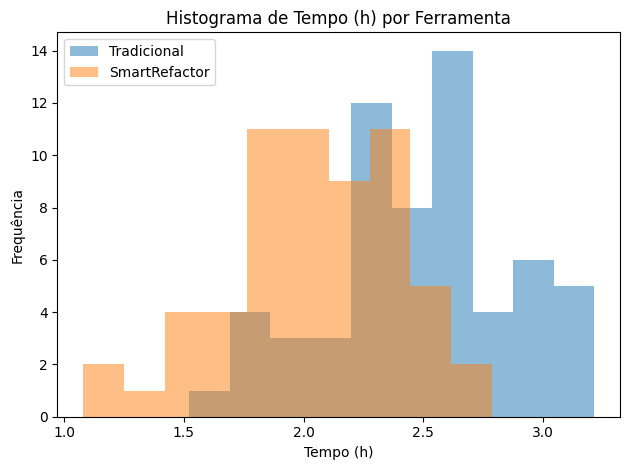

In [33]:
ordinals = {
    'experiencia': ["0-1 anos","1-2 anos","3-5 anos","6+ anos"],
    'kn_ref':      ["Nenhum","Básico","Razoável","Avançado"],
    'kn_java':     ["Nenhum","Básico","Razoável","Avançado"]
}
for col, order in ordinals.items():
    df[f"{col}_num"] = df[col].map({cat:i for i,cat in enumerate(order)}).astype(float)

# Spearman para as ordinais vs métricas
spearman_res = []
for num_col, label in [('experiencia_num','Experiência'),
                       ('kn_ref_num','Conhecimento Refatoração'),
                       ('kn_java_num','Conhecimento Java')]:
    for metric in ['tempo_h','erros','design']:
        coef, p = stats.spearmanr(df[num_col], df[metric], nan_policy='omit')
        spearman_res.append({
            'Variável': label,
            'Métrica': metric,
            'Teste': 'Spearman ρ',
            'Estatística': round(coef,3),
            'p_valor': round(p,5)
        })

# Kruskal–Wallis para todas as categóricas vs métricas
cat_vars = [
    ('formacao','Formação'),
    ('experiencia','Experiência'),
    ('kn_ref','Conhecimento Refatoração'),
    ('kn_java','Conhecimento Java'),
    ('Genero','Gênero'),
    ('FaixaEtaria','Faixa Etária'),
    ('AreaAtuacao','Área de Atuação'),
    ('Regiao','Região')
]
kw_res = []
for col, label in cat_vars:
    for metric in ['tempo_h','erros','design']:
        groups = [df[df[col]==cat][metric].dropna() for cat in df[col].dropna().unique()]
        if len(groups) > 1:
            H, p = stats.kruskal(*groups)
            kw_res.append({
                'Variável': label,
                'Métrica': metric,
                'Teste': 'Kruskal–Wallis',
                'Estatística': round(H,3),
                'p_valor': round(p,5)
            })

# Salvar
results = pd.DataFrame(spearman_res + kw_res)
results.to_csv(Path("./results/profile_influence.csv"), index=False)
display(results)

# Box-plot de Experiência × Erros Funcionais
exp_order = ["0-1 anos","1-2 anos","3-5 anos","6+ anos"]
data = [df[df["experiencia"]==lvl]["erros"].dropna() for lvl in exp_order]

plt.figure(figsize=(8,5))
plt.boxplot(data, labels=exp_order, showfliers=True)
plt.title("Erros Funcionais por Faixa de Experiência", fontweight="bold")
plt.xlabel("Experiência em Java", fontweight="bold")
plt.ylabel("Erros Funcionais", fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("results/boxplot_exp_err.png", dpi=300)
plt.show()

# Box-plot de Região × Problemas de Design
regions = ["Norte","Nordeste","Centro-Oeste","Sudeste","Sul"]
data = [df[df["Regiao"]==r]["design"].dropna() for r in regions]

plt.figure(figsize=(8,5))
plt.boxplot(data, labels=regions, showfliers=True)
plt.title("Problemas de Design por Região de Residência", fontweight="bold")
plt.xlabel("Região", fontweight="bold")
plt.ylabel("Problemas de Design", fontweight="bold")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("results/boxplot_regiao_design.png", dpi=300)
plt.show()

# Gráfico de Barras para Testes de Kruskal–Wallis
kw = results[(results["Teste"]=="Kruskal–Wallis") & (results["Métrica"]=="erros")]

plt.figure(figsize=(8,4))
plt.bar(kw["Variável"], kw["Estatística"])
plt.title("Estatística H de Kruskal–Wallis por Variável (Erros)", fontweight="bold")
plt.xlabel("Variável de Perfil", fontweight="bold")
plt.ylabel("H (Kruskal–Wallis)", fontweight="bold")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("results/bar_h_kruskal_erros.png", dpi=300)
plt.show()

# Histograma de Tempo por Ferramenta
metrics['tempo_h'] = metrics['Tempo (h)'].astype(str).str.replace(",", ".").astype(float)
plt.figure()
for tool in metrics['Ferramenta'].unique():
    subset = metrics[metrics['Ferramenta']==tool]['tempo_h']
    plt.hist(subset, bins=10, alpha=0.5, label=tool)
plt.title("Histograma de Tempo (h) por Ferramenta")
plt.xlabel("Tempo (h)")
plt.ylabel("Frequência")
plt.legend()
plt.tight_layout()
plt.savefig(out_dir/f"hist_tempo.png",dpi=300)
plt.show()


## 9. Box-plots das Métricas

<Figure size 640x480 with 0 Axes>

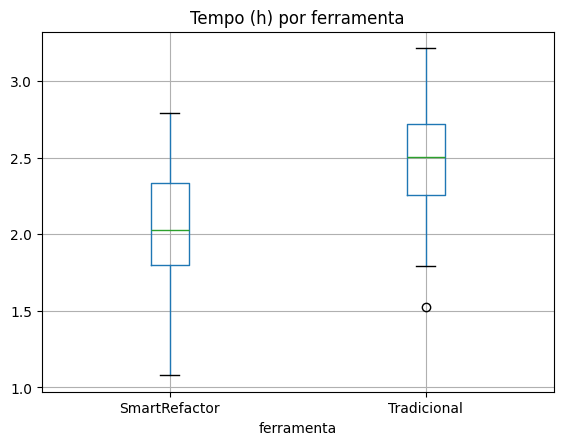

<Figure size 640x480 with 0 Axes>

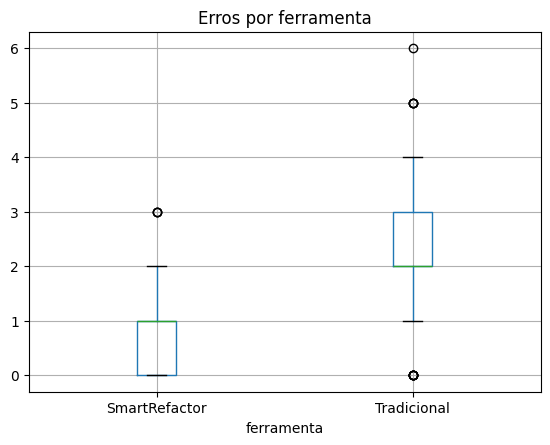

<Figure size 640x480 with 0 Axes>

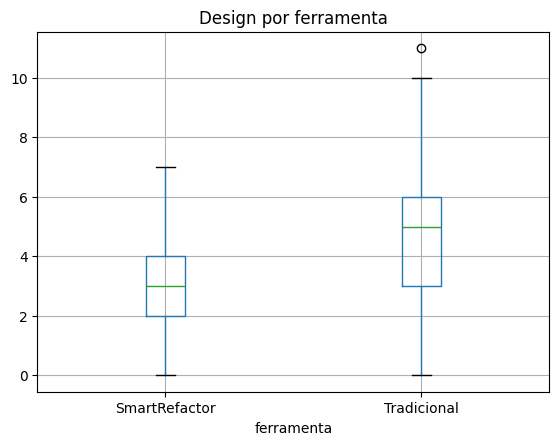

In [34]:
for metric,label in [("tempo_h","Tempo (h)"),("erros","Erros"),("design","Design")]:
    plt.figure()
    df.boxplot(column=metric,by="ferramenta")
    plt.title(label+" por ferramenta")
    plt.suptitle("")
    plt.savefig(out_dir/f"boxplot_{metric}.png",dpi=300)
    plt.show()
    plt.close()